<a href="https://colab.research.google.com/github/clebesa/Image-Classification/blob/main/FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


---


# **CS 4824/ECE 4424, Final Project**
##**Due before 11:59 PM Monday May 2, 2022**
---



**Instructions**:

1.   Honor code is enforced. This is an individual assignment. You should do your own work. Any evidence of copying will result in an immediate zero grade (0 point) and additional penalties/actions.
2.   Edits are only allowed at where 'TODO' tags exist. Edits made elsewhere will result in an immediate zero grade (0 point).
3.   Importing extra packages is forbidden. Any extra package import (including but not limited to numpy, scikit-learn, etc.) will result in an immediate zero grade (0 point).
4.   Please run each cell, including those that are collapsed, shown as `Show code`.
5.   Upon completion of this assignment, please download a '.ipynb' file through Taskbar > File > Download > .ipynb, then upload the file to Canvas. 

### **IMPORTANT NOTE:** ###


1.   **Your submitted .ipynb file should contain all the outputs, including the figures, images and run results, for each section. Due to the time-intensive nature of this assignment, the course staff WILL NOT re-run your code and reproduce your results. You will be graded based on your submitted .ipynb file containing all the outputs, including the figures, images and run results.**
2.   **You are strongly encouraged to do the assignment in Google Colab environment (as opposed to your local resources), frequently saving your work as you proceed. Refer to the expected runtime information of each section. These runtimes are provided based on simulations ran on Google Colab environment.**


 





# **1. Overview and Objective**
In this assignment, we will introduce the [Image Classification](https://cs231n.github.io/classification/) problem, which is the task of assigning an input image one label from a fixed set of categories. This is one of the core problems in Computer Vision that, despite its simplicity, has a large variety of practical applications. 

You will experiment with fully connected neural networks and convolutional neural networks, using the Keras open source package. Keras is one of the simplest deep learning packages that serves as a wrapper on top of TensorFlow. 

**Preliminary steps**: Familiarize yourself with [Keras](https://keras.io/). Click on [Guides](https://keras.io/guides/) and read the first two guides: "[The functional API](https://keras.io/guides/functional_api/)" and "[The Sequential Model](https://keras.io/guides/sequential_model/)".
Download and install Keras on a machine with a GPU or use Google's Colaboratory environment, which allows you to run Keras code on a GPU in the cloud. Colab already has Keras pre-installed. To enable GPU/TPU acceleration, click on **Edit** tab, then select **Notebook settings** and select **GPU** or **TPU** for hardware acceleration. TPUs are usually faster.

In [2]:
# libraries (do not import additional libraries)
from tensorflow import keras
from keras import optimizers
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint
import math
import numpy as np
import matplotlib.pyplot as plt
from keras.utils.np_utils import to_categorical
from scipy import misc
# from scipy import ndimage
import skimage.io
import skimage.filters

For designing the Neural Networks, we set the following parameters, which will remain unchanged for the rest of the assignment.

---



In [3]:
# parameters for this script
batch_size = 32
num_classes = 10
epochs = 25

## **2. Load the CIFAR10 dataset**

The **CIFAR10 dataset** is composed of of 50,000 *32x32* color training images and 10,000 test images, labeled over 10 categories. See more info at the [CIFAR homepage](https://www.cs.toronto.edu/~kriz/cifar.html). The image categories are:

  **Label**	**Description**

0.  airplane
1.  automobile
2. 	bird
3.	cat
4. 	deer
5. 	dog
6.	frog
7. 	horse
8.	ship
9.	truck

The `generate_data()` function imports the CIFAR10 dataset and returns the training set, validation set and test set.

**Returns** 

Tuple of NumPy arrays: `x_train, y_train, x_validate, y_validate, x_test, y_test`.

**x_train:** uint8 NumPy array of grayscale image data with shapes `(40000, 32, 32, 3)`, containing the training data. Pixel values range from 0 to 255.

**y_train:** uint8 NumPy array of labels (integers in range 0-9) with shape `(40000, 1)` for the training data.

**x_validate:** uint8 NumPy array of grayscale image data with shapes `(10000, 32, 32, 3)`, containing the test data. Pixel values range from 0 to 255.

**y_validate:** uint8 NumPy array of labels (integers in range 0-9) with shape `(10000, 1)` for the test data.

**x_test:** uint8 NumPy array of grayscale image data with shapes `(10000, 32, 32, 3)`, containing the test data. Pixel values range from 0 to 255.

**y_test:** uint8 NumPy array of labels (integers in range 0-9) with shape `(10000, 1)` for the test data.

In [4]:
def generate_data():
  # Load the data, split between train and test sets:
  (x_train, y_train), (x_test, y_test) = cifar10.load_data()
  print('x_train shape:', x_train.shape)
  print('y_train shape:', y_train.shape)
  print(x_train.shape[0], 'train samples')
  print(x_test.shape[0], 'test samples')

  # Convert class vectors to binary class matrices.
  y_train = to_categorical(y_train, num_classes)
  y_test = to_categorical(y_test, num_classes)
  # normalize the data
  x_train = x_train.astype('float32')
  x_test = x_test.astype('float32')
  x_train /= 255
  x_test /= 255

  # partition training set into training and validation set
  x_validate = x_train[40000:,:]
  x_train = x_train[:40000,:]
  y_validate = y_train[40000:,:]
  y_train = y_train[:40000,:]

  return x_train, y_train, x_validate, y_validate, x_test, y_test

In [5]:
x_train, y_train, x_validate, y_validate, x_test, y_test = generate_data()

170508288/170498071 [==============================] - 2s 0us/step
x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
50000 train samples
10000 test samples


In [6]:
for i in range(10000):
  # x_test[i] = ndimage.gaussian_filter(x_test[i], sigma=3)
  x_train[i] = skimage.filters.gaussian(
    x_train[i], sigma=(2, 2), truncate=2.5, multichannel=True)
  x_test[i] = skimage.filters.gaussian(
    x_test[i], sigma=(2, 2), truncate=2.5, multichannel=True)
  x_validate[i] = skimage.filters.gaussian(
    x_validate[i], sigma=(2, 2), truncate=2.5, multichannel=True)

# **3. Visualize the data [5 points]**
To better understand the dataset, let's plot the first 25 images from the training set and display the class name below each image:

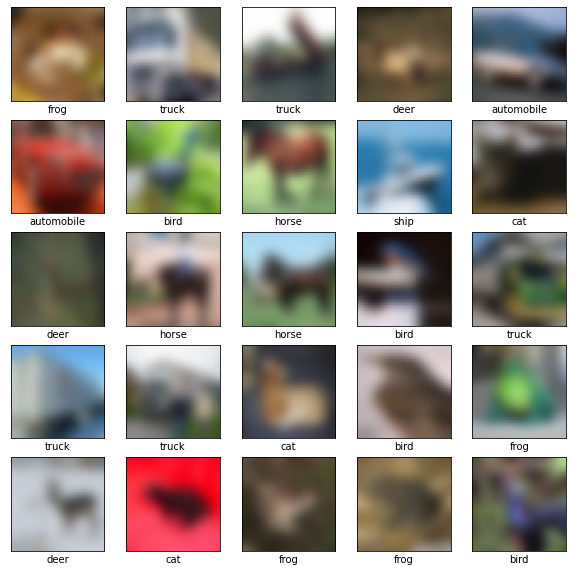

In [7]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    ax = plt.subplot(5,5,i+1)
    '''
    TO-DO: Write the code to print the i-th image from the training set. Make 
    sure that each image doesn't contain numeric values along both axes. The 
    output should show only the images and their labels.
    '''
    plt.imshow(x_train[i])
    ax.set_yticks([])
    ax.set_xticks([])
    
    
    # The CIFAR labels happen to be arrays, which is why you need the extra index
    plt.xlabel(class_names[np.nonzero(y_train[i])[0][0]])
plt.show()

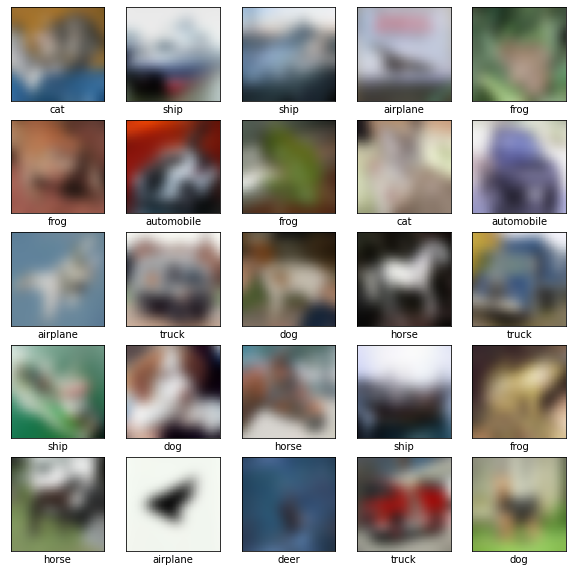

In [8]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    ax = plt.subplot(5,5,i+1)
    '''
    TO-DO: Write the code to print the i-th image from the training set. Make 
    sure that each image doesn't contain numeric values along both axes. The 
    output should show only the images and their labels.
    '''
    plt.imshow(x_test[i])
    ax.set_yticks([])
    ax.set_xticks([])
    
    
    # The CIFAR labels happen to be arrays, which is why you need the extra index
    plt.xlabel(class_names[np.nonzero(y_test[i])[0][0]])
plt.show()

## **4. The basic Convolutional Neural Network (CNN) architecture**
We define a basic CNN here using the [Keras Sequential API](https://www.tensorflow.org/guide/keras/overview).

As input, a CNN takes tensors of shape (image_height, image_width, color_channels). If you are new to these dimensions, color_channels refers to (R,G,B). In this example, you will configure your CNN to process inputs of shape (32, 32, 3), which is the format of CIFAR images. You can do this by passing the argument input_shape to your first layer.

Then, we define the convolutional base using a common pattern: a stack of [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D), [MaxPooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) and [dropout](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) layers.

The output of every Conv2D and MaxPooling2D layer is a 3D tensor of shape (height, width, channels). The width and height dimensions tend to shrink as you go deeper in the network. The number of output channels for each Conv2D layer is controlled by the first argument (e.g., 32 or 64). Typically, as the width and height shrink, you can afford (computationally) to add more output channels in each Conv2D layer.

To complete the model, you will feed the last output tensor from the convolutional base (of shape (8, 8, 64)) into one or more Dense layers to perform classification. Dense layers take vectors as input (which are 1D), while the current output is a 3D tensor. First, you will flatten (or unroll) the 3D output to 1D, then add one or more Dense layers on top. CIFAR has 10 output classes, so you use a final Dense layer with 10 outputs.

Note that we are using [RMSProp](https://keras.io/api/optimizers/rmsprop/) as the optimizer for learning the weights of the CNN. We supply the values of `learning_rate` and `decay` parameter to the RMSProp optimizer. Do not modify them.

The loss function used here is [categorical crossentropy](https://peltarion.com/knowledge-center/documentation/modeling-view/build-an-ai-model/loss-functions/categorical-crossentropy) that is used in multi-class classification tasks. These are tasks where an example can only belong to one out of many possible categories, and the model must decide which one. Formally, it is designed to quantify the difference between two probability distributions. The categorical crossentropy loss function calculates the loss of an example by computing the following:

$$Loss = - \sum_{i=1}^{output \; size} y_i . \log \hat y_i$$


where the outputs are in the form of probability distributions

`output prediction` 

$ {\bf \hat y} = [0.2\; \; 0.7 \; \; \hat y_i\; \;  0.1]$

`target` 

${\bf y} = [\;\;0\; \; \;\;\;1 \; \; y_i\; \; \; \; 0]$

In [9]:
def base_cnn():
  """
  Define a convolutional neural network using the Sequential model. This is the 
  basic CNN that you will need to reuse for the remaining parts of the assignment.
  It would be good to familiarize yourself with the workings of this basic CNN.
  """
  model = Sequential()
  '''
  Add 2D convolution layers the perform spatial convolution over images. This 
  layer creates a convolution kernel that is convolved with the layer input to 
  produce a tensor of outputs. When using this layer as the first layer in a 
  model, provide the keyword argument 'input_shape' (tuple of integers). Besides,
  the Conv2D function takes as input
  - filters: Integer, the dimensionality of the output space (i.e. the number of
   output filters in the convolution). We set it to 32.
  - kernel_size: An integer or tuple/list of 2 integers, specifying the height
   and width of the 2D convolution window. Can be a single integer to specify 
   the same value for all spatial dimensions. We set it to (3, 3).

  Here, we create a stack of (CONV2D, Activation, CONV2D, Activation) layers with 
  the ReLu activation function 
  '''
  model.add(Conv2D(32, (3, 3), padding='same',input_shape=x_train.shape[1:]))
  model.add(Activation('relu'))
  model.add(Conv2D(32, (3, 3), padding='same'))
  model.add(Activation('relu'))
  '''
  Perform MaxPooling operation for 2D spatial data. This downsamples the input
  along its spatial dimensions (height and width) by taking the maximum value 
  over an input window of size 2X2 for each channel of the input.
  '''
  model.add(MaxPooling2D(pool_size=(2, 2)))
  '''
  Add a Dropout layer that  randomly sets input units to 0 with a frequency of
  'rate' at each step during training time, which helps prevent overfitting. 
  Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all
  inputs is unchanged. We set the rate to 0.25 for Dropout.
  '''
  model.add(Dropout(0.25))
  '''
  Create another stack of (CONV2D, Activation, CONV2D, Activation) layers with 
  the ReLu activation function. Set the 'filters' to 64.
  '''
  model.add(Conv2D(64, (3, 3), padding='same'))
  model.add(Activation('relu'))
  model.add(Conv2D(64, (3, 3), padding='same'))
  model.add(Activation('relu'))
  '''
  Perfrom MaxPooling and Dropout similar to the one defined earlier.
  '''
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  '''
  The image is still in 3D. It needs be unrolled from 3D to 1D using the Flatten
  layer. Then add a Dense layers on top of it followed by ReLu activation and 
  dropout of 0.5. This helps to create a fully-connected layer.
  '''
  model.add(Flatten())
  model.add(Dense(512))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  '''
  Create the output layer using the Dense layer with 'softmax' activation. The 
  number of predicted output needs to be equal to 'num_classes'.
  '''
  model.add(Dense(num_classes))
  model.add(Activation('softmax'))
  '''
  Set the optimizer for doing mini-batch gradient descent. Here, we make use of 
  the RMSprop optimizer that comes with Keras. We supply some default values for
  the parameters learning_rate and decay. Do not modify them.
  '''
  opt = keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)
  '''
  Compile the model for training. Since this is a multi-class classification 
  problem, we use the 'categorical_crossentropy' loss function and 'accuracy' as
  the desired performance metric.
  '''
  model.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])
  print(model.summary())

  return model

## **5. Activation functions for CNN [20 points]**

### **a) Compare the activation fuctions ReLu and Sigmoid [10 points]**

In this section, we see the effect of changing the activation functions in the above CNN architecture.

Compare the accuracy achieved by **rectified linear** units and **sigmoid** units in the base CNN. Produce two graphs (one for training accuracy and one for validation accuracy) that each contain 2 curves (one for rectified linear units and another one for sigmoid units). The y-axis is the accuracy and the x-axis is the number of epochs. Train the neural networks for 25 epochs. Although 25 epochs is not sufficient to reach convergence, it is sufficient to see the trend. Save the following results in your Jupyter notebook:


*   The two graphs for training and validation accuracy.
*   For each activation function, print the test accuracy of the model that achieved the best validation accuracy among all epochs (i.e., one best test accuracy per activation function).



In [ ]:
def base_cnn_activation(activation):
  """
  TO-DO: Copy the code from the base_cnn() function above and paste it here. 
  This starter code sets the activation function to 'relu' by default. Modify 
  the code so that it can work with an user-supplied activation functions.Refer 
  to the simulation code below to understand the possible values that the input
  'activation' may take.
  """

  """
  Define a convolutional neural network using the Sequential model. This is the 
  basic CNN that you will need to reuse for the remaining parts of the assignment.
  It would be good to familiarize yourself with the workings of this basic CNN.
  """
  model = Sequential()
  '''
  Add 2D convolution layers the perform spatial convolution over images. This 
  layer creates a convolution kernel that is convolved with the layer input to 
  produce a tensor of outputs. When using this layer as the first layer in a 
  model, provide the keyword argument 'input_shape' (tuple of integers). Besides,
  the Conv2D function takes as input
  - filters: Integer, the dimensionality of the output space (i.e. the number of
   output filters in the convolution). We set it to 32.
  - kernel_size: An integer or tuple/list of 2 integers, specifying the height
   and width of the 2D convolution window. Can be a single integer to specify 
   the same value for all spatial dimensions. We set it to (3, 3).

  Here, we create a stack of (CONV2D, Activation, CONV2D, Activation) layers with 
  the ReLu activation function 
  '''
  model.add(Conv2D(32, (3, 3), padding='same',input_shape=x_train.shape[1:]))
  model.add(Activation(activation))
  model.add(Conv2D(32, (3, 3), padding='same'))
  model.add(Activation(activation))
  '''
  Perform MaxPooling operation for 2D spatial data. This downsamples the input
  along its spatial dimensions (height and width) by taking the maximum value 
  over an input window of size 2X2 for each channel of the input.
  '''
  model.add(MaxPooling2D(pool_size=(2, 2)))
  '''
  Add a Dropout layer that  randomly sets input units to 0 with a frequency of
  'rate' at each step during training time, which helps prevent overfitting. 
  Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all
  inputs is unchanged. We set the rate to 0.25 for Dropout.
  '''
  model.add(Dropout(0.25))
  '''
  Create another stack of (CONV2D, Activation, CONV2D, Activation) layers with 
  the ReLu activation function. Set the 'filters' to 64.
  '''
  model.add(Conv2D(64, (3, 3), padding='same'))
  model.add(Activation(activation))
  model.add(Conv2D(64, (3, 3), padding='same'))
  model.add(Activation(activation))
  '''
  Perfrom MaxPooling and Dropout similar to the one defined earlier.
  '''
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  '''
  The image is still in 3D. It needs be unrolled from 3D to 1D using the Flatten
  layer. Then add a Dense layers on top of it followed by ReLu activation and 
  dropout of 0.5. This helps to create a fully-connected layer.
  '''
  model.add(Flatten())
  model.add(Dense(512))
  model.add(Activation(activation))
  model.add(Dropout(0.5))
  '''
  Create the output layer using the Dense layer with 'softmax' activation. The 
  number of predicted output needs to be equal to 'num_classes'.
  '''
  model.add(Dense(num_classes))
  model.add(Activation('softmax'))
  '''
  Set the optimizer for doing mini-batch gradient descent. Here, we make use of 
  the RMSprop optimizer that comes with Keras. We supply some default values for
  the parameters learning_rate and decay. Do not modify them.
  '''
  opt = keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)
  '''
  Compile the model for training. Since this is a multi-class classification 
  problem, we use the 'categorical_crossentropy' loss function and 'accuracy' as
  the desired performance metric.
  '''
  model.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])
  print(model.summary())

  return model

### Test code to simulate this scenario (**do not modify**)


**Expected runtime on Google Colab:** 30-60 minutes with TPU/GPU resources.

Training CNN with relu activation function
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
             

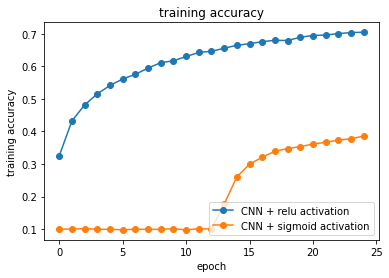

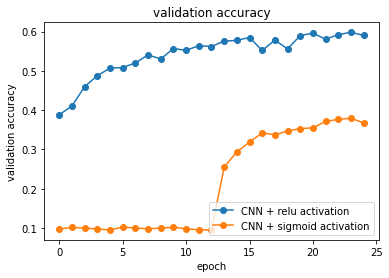

313/313 [==============================] - 3s 7ms/step - loss: 1.1510 - accuracy: 0.5949
Test accuracy for relu activation: 0.5949000120162964
313/313 [==============================] - 2s 7ms/step - loss: 1.6860 - accuracy: 0.3952
Test accuracy for sigmoid activation: 0.3952000141143799


In [ ]:
# create a callback that will save the best model while training
history_activations = dict()

for activation in ['relu', 'sigmoid']:
  print('Training CNN with {} activation function'.format(activation))
  save_best_model = ModelCheckpoint('best_model.{}'.format(activation), monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)
  model =  base_cnn_activation(activation)
  history_activations[activation] = model.fit(x_train, y_train,
                                              batch_size=batch_size,
                                              epochs=epochs,
                                              validation_data=(x_validate, y_validate),
                                              shuffle=True,
                                              callbacks=[save_best_model])
# Plot training accuracy
for activation in ['relu', 'sigmoid']:
  plt.plot(history_activations[activation].history['accuracy'], 'o-', label='CNN + {} activation'.format(activation))

plt.title('training accuracy')
plt.ylabel('training accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.show()

# Plot validation accuracy
for activation in ['relu', 'sigmoid']:
  plt.plot(history_activations[activation].history['val_accuracy'], 'o-', label='CNN + {} activation'.format(activation))
plt.title('validation accuracy')
plt.ylabel('validation accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.show()

# Evaluate the best model saved (i.e., model with best validation accuracy) on the test set
for activation in ['relu', 'sigmoid']:
  saved_model = load_model('best_model.{}'.format(activation))
  scores = saved_model.evaluate(x_test, y_test, verbose=1)
  print('Test accuracy for {} activation: {}'.format(activation, scores[1]))

### **b) Based on the above experiment answer the following [5 + 2.5 + 2.5 = 10 points]**

1.   After 25 epochs, what is the validation accuracy of the two activation functions?
2.   When does the validation accuracy start to improve for the sigmoid activation?
3. For RELU, when do you observe the saturation of validation accuracy? Saturation here refers to the accuracy change being less than 0.02 for 5 consecutive epochs or more.

Provide your answers in the text box below.

**Answers**


1.  RELU val_accuracy: 76.22 | Sigmoid val_accuracy: 42.80
2.  The value improved at Epoch 9 from 0.10250 to 0.11150
3.  Epoch 20 - 24



## **6. Simple dense neural networks vs the basic CNN [25 points]**

### **a) Comparing simple dense neural networks with** *l* **hidden layers with the basic CNN [15 points]**

Compare the accuracy of the **basic CNN** (with ReLu activation) defined earlier on the CIFAR10 dataset to the accuracy of simple dense neural networks (DNN) with **1** and **2** hidden layers of **512** rectified linear units each. The results of the **basic CNN** is stored in the *history_activations* dictionary. Modify the code in **base_dnn()** to obtain simple dense neural networks with **1** and **2** hidden layers of *512* rectified linear units (with a dropout rate of 0.5). 

Produce two graphs that contain 3 curves (one for the convolutional neural net and one for each dense neural net of 1-2 hidden layers). The *y-axis* is the accuracy and the *x-axis* is the number of epochs (\# of passes through the training set). 

Since neural networks take a while to train, cross-validation is not practical. Instead, produce one graph where all the curves correspond to the training accuracy and a second graph where all the curves correspond to the validation accuracy. Train the neural networks for 25 epochs. Although 25 epochs is not sufficient to reach convergence, it is sufficient to see the trend. Among the models abtained after each epoch, save the model that achieves the best validation accuracy and report its test accuracy. Save the following results in your Jupyter notebook:


*   The two graphs for training and validation accuracy.
*   For each architecture, print the test accuracy of the model that achieved the best validation accuracy among all epochs (i.e., one best test accuracy per network architecture).





In [ ]:
def base_dnn(hidden_layer=0):
  # Define a dense neural network containing 'hidden_layer' + 1 hidden layers.
  model = Sequential()

  '''
  TO-DO: A dense layer which takes the data as input and outputs are passed to
  the first hidden layer containing 512 units. Use 'relu' activation function
  '''
  model.add(Dense(512,input_shape=x_train.shape[1:]))
  model.add(Activation('relu'))

  '''
  TO-DO: Add a for loop for stacking the additional hidden layers based on the
  input 'hidden_layer'. This loop should run from 0 to hidden_layer-1. Make 
  sure that the output dimension of each additional hidden layer is 512. Also,
  add a droput of 0.5 after adding each hidden layer.
  '''
  
  for i in range(hidden_layer - 1):
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

  # The outputs are flattened for subsequent layers
  model.add(Flatten())
  
  '''
  TO-DO: Use the dense layer to generate an output of size 'num_classes'. Use
  the 'softmax' activation function.
  '''
  model.add(Dense(num_classes))
  model.add(Activation('softmax'))

  # initiate RMSprop optimizer
  opt = keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)

  # Compile the model before using it
  model.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])
  print(model.summary())

  return model

### Test code to simulate this scenario (**do not modify**)

**Expected runtime on Google Colab:** 60-120 minutes with TPU/GPU resources

Training DNN with 1 hidden layers
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 32, 32, 512)       2048      
                                                                 
 activation_12 (Activation)  (None, 32, 32, 512)       0         
                                                                 
 flatten_2 (Flatten)         (None, 524288)            0         
                                                                 
 dense_5 (Dense)             (None, 10)                5242890   
                                                                 
 activation_13 (Activation)  (None, 10)                0         
                                                                 
Total params: 5,244,938
Trainable params: 5,244,938
Non-trainable params: 0
_________________________________________________________________
None
Epoch

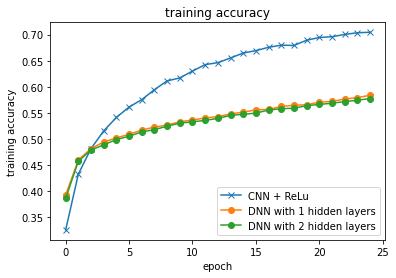

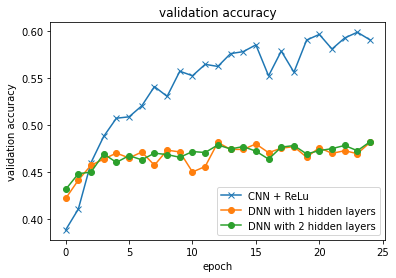

313/313 [==============================] - 4s 11ms/step - loss: 1.4932 - accuracy: 0.4844
Test accuracy for DNN with 1 hidden layers: 0.4844000041484833
313/313 [==============================] - 4s 11ms/step - loss: 1.4795 - accuracy: 0.4866
Test accuracy for DNN with 2 hidden layers: 0.48660001158714294


In [ ]:
history_dnn = dict()
for l in range(2):
  print('Training DNN with {} hidden layers'.format(l+1))
  save_best_model = ModelCheckpoint('best_model.{}hiddenlayers'.format(l+1), monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)
  model =  base_dnn(l)
  history_dnn[l] = model.fit(x_train, y_train,
                             batch_size=batch_size,
                             epochs=epochs,
                             validation_data=(x_validate, y_validate),
                             shuffle=True,
                             callbacks=[save_best_model])
  
# Plot training accuracy
plt.plot(history_activations['relu'].history['accuracy'], 'x-', label='CNN + ReLu')
for l in range(2):
  plt.plot(history_dnn[l].history['accuracy'], 'o-', label='DNN with {} hidden layers'.format(l+1))

plt.title('training accuracy')
plt.ylabel('training accuracy')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.show()

# Plot validation accuracy
plt.plot(history_activations['relu'].history['val_accuracy'], 'x-', label='CNN + ReLu')
for l in range(2):
  plt.plot(history_dnn[l].history['val_accuracy'], 'o-', label='DNN with {} hidden layers'.format(l+1))
  
plt.title('validation accuracy')
plt.ylabel('validation accuracy')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.show()

# Evaluate the best model saved (i.e., model with best validation accuracy) on the test set
for l in range(2):
  saved_model = load_model('best_model.{}hiddenlayers'.format(l+1))
  scores = saved_model.evaluate(x_test, y_test, verbose=1)
  print('Test accuracy for DNN with {} hidden layers: {}'.format(l+1, scores[1]))

### **b) Based on the above experiment answer the following [2.5X4 = 10 points]**


1. What are the validation accuracy of the comparison models after 25 epochs?

2. Do you get any added benefit by adding more hidden layers?

3. Is the validation accuracy a strictly non-decreasing function of the number of epochs?

4. Would you prefer a CNN or a DNN if you were to classify images based on your experimental results? Why?

Provide your answers in the text box below.


### **Answers**


1. With 1 Hidden layer: 0.4918 | With 2 Hidden layers: 0.4913

2. No, validation accuracy decreased

3. No, it fluctuates

4. A CNN. A CNN has higher val_accuracy and had a non-decreasing validation accuracy

## **7. The effects of dropout on CNN [25 points]**

### **a) Compare the accuracy achieved with and without drop on the basic CNN [15 points]**

Complete the code in `base_cnn_drop()` to turn the dropout layer on/off dropout based on the input `dropout`. 

Produce two graphs (one for training accuracy and the other one for validation accuracy) that each contain 2 curves (dropout and no dropout). The y-axis is the accuracy and the x-axis is the number of epochs. Produce curves for up to 25 epochs.

*   The two graphs for training and validation accuracy.
*   For both dropout and no dropout, print the test accuracy of the model that achieved the best validation accuracy among all epochs.





In [ ]:
def base_cnn_drop(dropout):
  """
  TO-DO: Copy the code from the base_cnn() function above and paste it here. This
  code has three occurences of the dropout layer. Modify those occurences so that 
  dropout layer is added based on the input 'dropout'. See the simulation code 
  below to see the possible values of input 'dropout'.
  """
  """
  TO-DO: Copy the code from the base_cnn() function above and paste it here. 
  This starter code sets the activation function to 'relu' by default. Modify 
  the code so that it can work with an user-supplied activation functions.Refer 
  to the simulation code below to understand the possible values that the input
  'activation' may take.
  """

  """
  Define a convolutional neural network using the Sequential model. This is the 
  basic CNN that you will need to reuse for the remaining parts of the assignment.
  It would be good to familiarize yourself with the workings of this basic CNN.
  """
  model = Sequential()
  '''
  Add 2D convolution layers the perform spatial convolution over images. This 
  layer creates a convolution kernel that is convolved with the layer input to 
  produce a tensor of outputs. When using this layer as the first layer in a 
  model, provide the keyword argument 'input_shape' (tuple of integers). Besides,
  the Conv2D function takes as input
  - filters: Integer, the dimensionality of the output space (i.e. the number of
   output filters in the convolution). We set it to 32.
  - kernel_size: An integer or tuple/list of 2 integers, specifying the height
   and width of the 2D convolution window. Can be a single integer to specify 
   the same value for all spatial dimensions. We set it to (3, 3).

  Here, we create a stack of (CONV2D, Activation, CONV2D, Activation) layers with 
  the ReLu activation function 
  '''
  model.add(Conv2D(32, (3, 3), padding='same',input_shape=x_train.shape[1:]))
  model.add(Activation('relu'))
  model.add(Conv2D(32, (3, 3), padding='same'))
  model.add(Activation('relu'))
  '''
  Perform MaxPooling operation for 2D spatial data. This downsamples the input
  along its spatial dimensions (height and width) by taking the maximum value 
  over an input window of size 2X2 for each channel of the input.
  '''
  model.add(MaxPooling2D(pool_size=(2, 2)))
  '''
  Add a Dropout layer that  randomly sets input units to 0 with a frequency of
  'rate' at each step during training time, which helps prevent overfitting. 
  Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all
  inputs is unchanged. We set the rate to 0.25 for Dropout.
  '''
  if dropout:
    model.add(Dropout(0.25))
  '''
  Create another stack of (CONV2D, Activation, CONV2D, Activation) layers with 
  the ReLu activation function. Set the 'filters' to 64.
  '''
  model.add(Conv2D(64, (3, 3), padding='same'))
  model.add(Activation('relu'))
  model.add(Conv2D(64, (3, 3), padding='same'))
  model.add(Activation('relu'))
  '''
  Perfrom MaxPooling and Dropout similar to the one defined earlier.
  '''
  model.add(MaxPooling2D(pool_size=(2, 2)))
  if dropout:
    model.add(Dropout(0.25))
  '''
  The image is still in 3D. It needs be unrolled from 3D to 1D using the Flatten
  layer. Then add a Dense layers on top of it followed by ReLu activation and 
  dropout of 0.5. This helps to create a fully-connected layer.
  '''
  model.add(Flatten())
  model.add(Dense(512))
  model.add(Activation('relu'))
  if dropout:
    model.add(Dropout(0.5))
  '''
  Create the output layer using the Dense layer with 'softmax' activation. The 
  number of predicted output needs to be equal to 'num_classes'.
  '''
  model.add(Dense(num_classes))
  model.add(Activation('softmax'))
  '''
  Set the optimizer for doing mini-batch gradient descent. Here, we make use of 
  the RMSprop optimizer that comes with Keras. We supply some default values for
  the parameters learning_rate and decay. Do not modify them.
  '''
  opt = keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)

  '''
  Compile the model for training. Since this is a multi-class classification 
  problem, we use the 'categorical_crossentropy' loss function and 'accuracy' as
  the desired performance metric.
  '''
  model.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])
  print(model.summary())

  return model

### Test code to simulate this scenario (**do not modify**)

**Expected runtime on Google Colab:** 30-60 minutes with TPU/GPU resources

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 activation_16 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 activation_17 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 16, 16, 32)        0         
                                                      

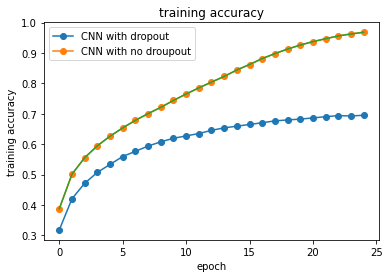

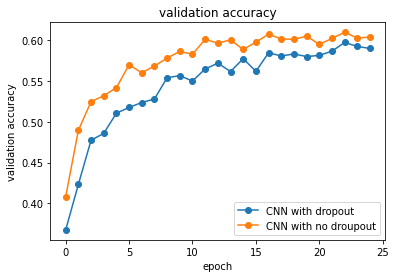

313/313 [==============================] - 2s 7ms/step - loss: 1.1758 - accuracy: 0.5919
Test accuracy for CNN with dropout :
313/313 [==============================] - 2s 7ms/step - loss: 1.5475 - accuracy: 0.6143
Test accuracy for CNN with no droupout :


In [ ]:
history_dd = dict()

for dropout in [True, False]:
  model = base_cnn_drop(dropout)
  model_name = ('no droupout', 'dropout')[dropout]
  save_best_model = ModelCheckpoint('best_model.{}'.format(model_name),
                                    monitor='val_accuracy', mode='max',
                                    save_best_only=True, verbose=1)

  history = model.fit(x_train, y_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      validation_data=(x_validate, y_validate),
                      shuffle=True,
                      callbacks=[save_best_model])
  
  history_dd[model_name] = history


# Plot training accuracy
for model_name, history in history_dd.items():
  plt.plot(history.history['accuracy'], 'o-', label='CNN with {}'.format(model_name))
plt.plot(history.history['accuracy'])
plt.title('training accuracy')
plt.ylabel('training accuracy')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.show()

# Plot validation accuracy
for model_name, history in history_dd.items():
  plt.plot(history.history['val_accuracy'], 'o-', label='CNN with {}'.format(model_name))
plt.title('validation accuracy')
plt.ylabel('validation accuracy')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.show()

# Evaluate the best model saved (i.e., model with best validation accuracy) on the test set
for model_name in history_dd.keys():
  saved_model = load_model('best_model.{}'.format(model_name))
  scores = saved_model.evaluate(x_test, y_test, verbose=1)
  print('Test accuracy for CNN with {} :'.format(model_name, scores[1]))

### **b) Based on the above experiment answer the following [2.5x4 = 10 points]**

1. What is the training accuracy of both the models after 25 epochs?

2. What is the validation accuracy of both the models after 25 epochs?

3. Between the two models (CNN with dropout and CNN without dropout), which one fits the training data better? Does this model fit the validation data better as well?

4. Based on your previous answer, which model would you prefer when deploying your ML model for image classification?


Provide your answers in the text box below.

### **Answers**


1. Without dropout: 98.85 | With dropout: 76.17

2. Without dropout: 71.09 | With dropout: 75.42

3. Without dropout fits the training data better. However, the model with dropouts fits the validation better.

4. The CNN with dropout model


## **8. The effects of optimizers on the CNN [15 points]**

### **a) Compare the accuracy achieved when training the basic CNN with RMSprop, Adagrad and Adam [10 points]**. 
Modify the code in `base_cnn_opt()` to use the **Adagrad** and **Adam** optimizers (with default parameters) besides the **RMSprop**. Produce two graphs (one for training accuracy and the other one for validation accuracy) that each contain 3 curves (for **RMSprop**, **Adagrad** and **Adam**). The y-axis is the accuracy and the x-axis is the number of epochs. Produce curves for as many epochs as you can up to 100 epochs.

*   The two graphs for training and validation accuracy.
*   For each optimizer print the test accuracy of the model that achieved the best validation accuracy among all epochs (i.e., one best test accuracy per optimizer).




In [ ]:
def base_cnn_opt(optimizer):
  """
  TO-DO: Copy the code from the base_cnn() function above and paste it here. 
  This started code uses the RMSprop for learning the weights of the basic CNN. 
  Modify the code so that it can work with Adagrad and Adam optimizers (besides 
  the provided RMSprop optimizer). Don't change the hyperparameters of the 
  RMSprop optimizer. For Adam and Adagrad, use the default hyperparameters. Refer
  to the simulation code below to understand the possible values that the input 
  'optimizer' may take and accordingly write your code.
  """
  """
  TO-DO: Copy the code from the base_cnn() function above and paste it here. 
  This starter code sets the activation function to 'relu' by default. Modify 
  the code so that it can work with an user-supplied activation functions.Refer 
  to the simulation code below to understand the possible values that the input
  'activation' may take.
  """

  """
  Define a convolutional neural network using the Sequential model. This is the 
  basic CNN that you will need to reuse for the remaining parts of the assignment.
  It would be good to familiarize yourself with the workings of this basic CNN.
  """
  model = Sequential()
  '''
  Add 2D convolution layers the perform spatial convolution over images. This 
  layer creates a convolution kernel that is convolved with the layer input to 
  produce a tensor of outputs. When using this layer as the first layer in a 
  model, provide the keyword argument 'input_shape' (tuple of integers). Besides,
  the Conv2D function takes as input
  - filters: Integer, the dimensionality of the output space (i.e. the number of
   output filters in the convolution). We set it to 32.
  - kernel_size: An integer or tuple/list of 2 integers, specifying the height
   and width of the 2D convolution window. Can be a single integer to specify 
   the same value for all spatial dimensions. We set it to (3, 3).

  Here, we create a stack of (CONV2D, Activation, CONV2D, Activation) layers with 
  the ReLu activation function 
  '''
  model.add(Conv2D(32, (3, 3), padding='same',input_shape=x_train.shape[1:]))
  model.add(Activation('relu'))
  model.add(Conv2D(32, (3, 3), padding='same'))
  model.add(Activation('relu'))
  '''
  Perform MaxPooling operation for 2D spatial data. This downsamples the input
  along its spatial dimensions (height and width) by taking the maximum value 
  over an input window of size 2X2 for each channel of the input.
  '''
  model.add(MaxPooling2D(pool_size=(2, 2)))
  '''
  Add a Dropout layer that  randomly sets input units to 0 with a frequency of
  'rate' at each step during training time, which helps prevent overfitting. 
  Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all
  inputs is unchanged. We set the rate to 0.25 for Dropout.
  '''
  model.add(Dropout(0.25))
  '''
  Create another stack of (CONV2D, Activation, CONV2D, Activation) layers with 
  the ReLu activation function. Set the 'filters' to 64.
  '''
  model.add(Conv2D(64, (3, 3), padding='same'))
  model.add(Activation('relu'))
  model.add(Conv2D(64, (3, 3), padding='same'))
  model.add(Activation('relu'))
  '''
  Perfrom MaxPooling and Dropout similar to the one defined earlier.
  '''
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  '''
  The image is still in 3D. It needs be unrolled from 3D to 1D using the Flatten
  layer. Then add a Dense layers on top of it followed by ReLu activation and 
  dropout of 0.5. This helps to create a fully-connected layer.
  '''
  model.add(Flatten())
  model.add(Dense(512))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  '''
  Create the output layer using the Dense layer with 'softmax' activation. The 
  number of predicted output needs to be equal to 'num_classes'.
  '''
  model.add(Dense(num_classes))
  model.add(Activation('softmax'))
  '''
  Set the optimizer for doing mini-batch gradient descent. Here, we make use of 
  the RMSprop optimizer that comes with Keras. We supply some default values for
  the parameters learning_rate and decay. Do not modify them.
  '''
  opt = keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)
  '''
  Compile the model for training. Since this is a multi-class classification 
  problem, we use the 'categorical_crossentropy' loss function and 'accuracy' as
  the desired performance metric.
  '''
  model.compile(loss='categorical_crossentropy',
                optimizer = optimizer,
                metrics=['accuracy'])
  print(model.summary())

  return model

### Test code to simulate the scenario (**do not modify**)

**Expected runtime on Google Colab:** 60-90 minutes with TPU/GPU resources

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 activation_28 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 conv2d_17 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 activation_29 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 16, 16, 32)        0         
                                                      

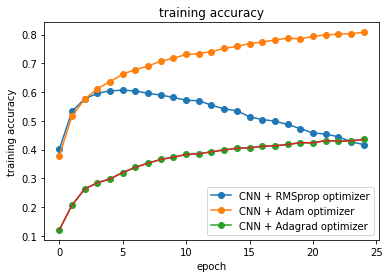

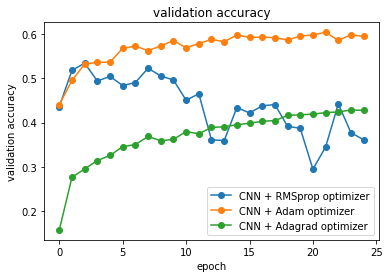

313/313 [==============================] - 3s 7ms/step - loss: 1.3041 - accuracy: 0.5342
Test accuracy for CNN + RMSprop optimizer: 0.5342000126838684
313/313 [==============================] - 3s 8ms/step - loss: 1.1606 - accuracy: 0.5984
Test accuracy for CNN + Adam optimizer: 0.5983999967575073
313/313 [==============================] - 3s 7ms/step - loss: 1.5972 - accuracy: 0.4428
Test accuracy for CNN + Adagrad optimizer: 0.44279998540878296


In [ ]:
history_opt = dict()

for optimizer in ['RMSprop', 'Adam', 'Adagrad']:
  save_best_model = ModelCheckpoint('best_model.{}'.format(optimizer), monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)
  model = base_cnn_opt(optimizer)
  history_opt[optimizer] = model.fit(x_train, y_train,
                          batch_size=batch_size,
                          epochs=epochs,
                          validation_data=(x_validate, y_validate),
                          shuffle=True,
                          callbacks=[save_best_model])

# Plot training accuracy
for model_name, history in history_opt.items():
  plt.plot(history.history['accuracy'], 'o-', label='CNN + {} optimizer'.format(model_name))
plt.plot(history.history['accuracy'])
plt.title('training accuracy')
plt.ylabel('training accuracy')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.show()

# Plot validation accuracy
for model_name, history in history_opt.items():
  plt.plot(history.history['val_accuracy'], 'o-', label='CNN + {} optimizer'.format(model_name))
plt.title('validation accuracy')
plt.ylabel('validation accuracy')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.show()

# Evaluate the best model saved (i.e., model with best validation accuracy) on the test set
for optimizer in ['RMSprop', 'Adam', 'Adagrad']:
  saved_model = load_model('best_model.{}'.format(optimizer))
  scores = saved_model.evaluate(x_test, y_test, verbose=1)
  print('Test accuracy for CNN + {} optimizer: {}'.format(optimizer, scores[1]))

### **b) Based on the above experiment answer the following [2.5x2 = 5 points]**

1. Rank the models in terms of performance on the training set?

2. Rank the models in terms of performance on the validation set?


Provide your answers in the text box below.



### **Answers**

1. In order (best to worst): CNN + Adam, CNN + RMSprop, CNN + Adagrad

2. In order (best to worst):CNN + Adam, CNN + RMSprop, CNN + Adagrad

## **9. The effects of convolutional filters on the CNN [10 points]**

### **a) Compare the base CNN with 3x3 filters against a modified CNN with 5x5 filters [5 points]**
The base CNN contains two stacks of **(CONV2D, Activation, CONV2D, Activation)** layers with **3x3 filters**. Create a modified CNN by replacing each of the bigger stacks with a smaller stack of **(CONV2D, Activation)** layers with **5x5 filters**. Do not change the output size in the smaller stack. Produce two graphs (one for training accuracy and the other one for validation accuracy) that each contain 2 curves (for 3x3 filters and 5x5 filters). The y-axis is the accuracy and the x-axis is the number of epochs. Produce curves for up to 25 epochs.

*   The two graphs for training and validation accuracy.
*   For each filter configuration, print the test accuracy of the model that achieved the best validation accuracy among all epochs (i.e., one best test accuracy per filter configuration).

In [10]:
def new_cnn11():
  """
  TO-DO: Copy the code from the base_cnn() function above and paste it here. 
  This started code has two stacks of (Conv2D, Activation, Conv2D, Activation) 
  layers with 3x3 filters. Replace each such stack with a smaller stack of 
  (Conv2D, Activation) layers with 5x5 filters. Do not change the output size of
  the the Conv2D filter. Any other parts of the code should remain unchanged.
  """
  """
  TO-DO: Copy the code from the base_cnn() function above and paste it here. 
  This starter code sets the activation function to 'relu' by default. Modify 
  the code so that it can work with an user-supplied activation functions.Refer 
  to the simulation code below to understand the possible values that the input
  'activation' may take.
  """

  """
  Define a convolutional neural network using the Sequential model. This is the 
  basic CNN that you will need to reuse for the remaining parts of the assignment.
  It would be good to familiarize yourself with the workings of this basic CNN.
  """
  model = Sequential()
  '''
  Add 2D convolution layers the perform spatial convolution over images. This 
  layer creates a convolution kernel that is convolved with the layer input to 
  produce a tensor of outputs. When using this layer as the first layer in a 
  model, provide the keyword argument 'input_shape' (tuple of integers). Besides,
  the Conv2D function takes as input
  - filters: Integer, the dimensionality of the output space (i.e. the number of
   output filters in the convolution). We set it to 32.
  - kernel_size: An integer or tuple/list of 2 integers, specifying the height
   and width of the 2D convolution window. Can be a single integer to specify 
   the same value for all spatial dimensions. We set it to (3, 3).

  Here, we create a stack of (CONV2D, Activation, CONV2D, Activation) layers with 
  the ReLu activation function 
  '''
  model.add(Conv2D(32, (11, 11), padding='same',input_shape=x_train.shape[1:]))
  model.add(Activation('relu'))
  '''
  Perform MaxPooling operation for 2D spatial data. This downsamples the input
  along its spatial dimensions (height and width) by taking the maximum value 
  over an input window of size 2X2 for each channel of the input.
  '''
  model.add(MaxPooling2D(pool_size=(2, 2)))
  '''
  Add a Dropout layer that  randomly sets input units to 0 with a frequency of
  'rate' at each step during training time, which helps prevent overfitting. 
  Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all
  inputs is unchanged. We set the rate to 0.25 for Dropout.
  '''
  model.add(Dropout(0.25))
  '''
  Create another stack of (CONV2D, Activation, CONV2D, Activation) layers with 
  the ReLu activation function. Set the 'filters' to 64.
  '''
  model.add(Conv2D(64, (11, 11), padding='same'))
  model.add(Activation('relu'))
  '''
  Perfrom MaxPooling and Dropout similar to the one defined earlier.
  '''
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  '''
  The image is still in 3D. It needs be unrolled from 3D to 1D using the Flatten
  layer. Then add a Dense layers on top of it followed by ReLu activation and 
  dropout of 0.5. This helps to create a fully-connected layer.
  '''
  model.add(Flatten())
  model.add(Dense(512))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  '''
  Create the output layer using the Dense layer with 'softmax' activation. The 
  number of predicted output needs to be equal to 'num_classes'.
  '''
  model.add(Dense(num_classes))
  model.add(Activation('softmax'))
  '''
  Set the optimizer for doing mini-batch gradient descent. Here, we make use of 
  the RMSprop optimizer that comes with Keras. We supply some default values for
  the parameters learning_rate and decay. Do not modify them.
  '''
  opt = keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)
  '''
  Compile the model for training. Since this is a multi-class classification 
  problem, we use the 'categorical_crossentropy' loss function and 'accuracy' as
  the desired performance metric.
  '''
  model.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])
  print(model.summary())

  return model

In [11]:
def new_cnn7():
  """
  TO-DO: Copy the code from the base_cnn() function above and paste it here. 
  This started code has two stacks of (Conv2D, Activation, Conv2D, Activation) 
  layers with 3x3 filters. Replace each such stack with a smaller stack of 
  (Conv2D, Activation) layers with 5x5 filters. Do not change the output size of
  the the Conv2D filter. Any other parts of the code should remain unchanged.
  """
  """
  TO-DO: Copy the code from the base_cnn() function above and paste it here. 
  This starter code sets the activation function to 'relu' by default. Modify 
  the code so that it can work with an user-supplied activation functions.Refer 
  to the simulation code below to understand the possible values that the input
  'activation' may take.
  """

  """
  Define a convolutional neural network using the Sequential model. This is the 
  basic CNN that you will need to reuse for the remaining parts of the assignment.
  It would be good to familiarize yourself with the workings of this basic CNN.
  """
  model = Sequential()
  '''
  Add 2D convolution layers the perform spatial convolution over images. This 
  layer creates a convolution kernel that is convolved with the layer input to 
  produce a tensor of outputs. When using this layer as the first layer in a 
  model, provide the keyword argument 'input_shape' (tuple of integers). Besides,
  the Conv2D function takes as input
  - filters: Integer, the dimensionality of the output space (i.e. the number of
   output filters in the convolution). We set it to 32.
  - kernel_size: An integer or tuple/list of 2 integers, specifying the height
   and width of the 2D convolution window. Can be a single integer to specify 
   the same value for all spatial dimensions. We set it to (3, 3).

  Here, we create a stack of (CONV2D, Activation, CONV2D, Activation) layers with 
  the ReLu activation function 
  '''
  model.add(Conv2D(32, (7, 7), padding='same',input_shape=x_train.shape[1:]))
  model.add(Activation('relu'))
  '''
  Perform MaxPooling operation for 2D spatial data. This downsamples the input
  along its spatial dimensions (height and width) by taking the maximum value 
  over an input window of size 2X2 for each channel of the input.
  '''
  model.add(MaxPooling2D(pool_size=(2, 2)))
  '''
  Add a Dropout layer that  randomly sets input units to 0 with a frequency of
  'rate' at each step during training time, which helps prevent overfitting. 
  Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all
  inputs is unchanged. We set the rate to 0.25 for Dropout.
  '''
  model.add(Dropout(0.25))
  '''
  Create another stack of (CONV2D, Activation, CONV2D, Activation) layers with 
  the ReLu activation function. Set the 'filters' to 64.
  '''
  model.add(Conv2D(64, (7, 7), padding='same'))
  model.add(Activation('relu'))
  '''
  Perfrom MaxPooling and Dropout similar to the one defined earlier.
  '''
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  '''
  The image is still in 3D. It needs be unrolled from 3D to 1D using the Flatten
  layer. Then add a Dense layers on top of it followed by ReLu activation and 
  dropout of 0.5. This helps to create a fully-connected layer.
  '''
  model.add(Flatten())
  model.add(Dense(512))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  '''
  Create the output layer using the Dense layer with 'softmax' activation. The 
  number of predicted output needs to be equal to 'num_classes'.
  '''
  model.add(Dense(num_classes))
  model.add(Activation('softmax'))
  '''
  Set the optimizer for doing mini-batch gradient descent. Here, we make use of 
  the RMSprop optimizer that comes with Keras. We supply some default values for
  the parameters learning_rate and decay. Do not modify them.
  '''
  opt = keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)
  '''
  Compile the model for training. Since this is a multi-class classification 
  problem, we use the 'categorical_crossentropy' loss function and 'accuracy' as
  the desired performance metric.
  '''
  model.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])
  print(model.summary())

  return model

In [12]:
def new_cnn5():
  """
  TO-DO: Copy the code from the base_cnn() function above and paste it here. 
  This started code has two stacks of (Conv2D, Activation, Conv2D, Activation) 
  layers with 3x3 filters. Replace each such stack with a smaller stack of 
  (Conv2D, Activation) layers with 5x5 filters. Do not change the output size of
  the the Conv2D filter. Any other parts of the code should remain unchanged.
  """
  """
  TO-DO: Copy the code from the base_cnn() function above and paste it here. 
  This starter code sets the activation function to 'relu' by default. Modify 
  the code so that it can work with an user-supplied activation functions.Refer 
  to the simulation code below to understand the possible values that the input
  'activation' may take.
  """

  """
  Define a convolutional neural network using the Sequential model. This is the 
  basic CNN that you will need to reuse for the remaining parts of the assignment.
  It would be good to familiarize yourself with the workings of this basic CNN.
  """
  model = Sequential()
  '''
  Add 2D convolution layers the perform spatial convolution over images. This 
  layer creates a convolution kernel that is convolved with the layer input to 
  produce a tensor of outputs. When using this layer as the first layer in a 
  model, provide the keyword argument 'input_shape' (tuple of integers). Besides,
  the Conv2D function takes as input
  - filters: Integer, the dimensionality of the output space (i.e. the number of
   output filters in the convolution). We set it to 32.
  - kernel_size: An integer or tuple/list of 2 integers, specifying the height
   and width of the 2D convolution window. Can be a single integer to specify 
   the same value for all spatial dimensions. We set it to (3, 3).

  Here, we create a stack of (CONV2D, Activation, CONV2D, Activation) layers with 
  the ReLu activation function 
  '''
  model.add(Conv2D(32, (5, 5), padding='same',input_shape=x_train.shape[1:]))
  model.add(Activation('relu'))
  '''
  Perform MaxPooling operation for 2D spatial data. This downsamples the input
  along its spatial dimensions (height and width) by taking the maximum value 
  over an input window of size 2X2 for each channel of the input.
  '''
  model.add(MaxPooling2D(pool_size=(2, 2)))
  '''
  Add a Dropout layer that  randomly sets input units to 0 with a frequency of
  'rate' at each step during training time, which helps prevent overfitting. 
  Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all
  inputs is unchanged. We set the rate to 0.25 for Dropout.
  '''
  model.add(Dropout(0.25))
  '''
  Create another stack of (CONV2D, Activation, CONV2D, Activation) layers with 
  the ReLu activation function. Set the 'filters' to 64.
  '''
  model.add(Conv2D(64, (5, 5), padding='same'))
  model.add(Activation('relu'))
  '''
  Perfrom MaxPooling and Dropout similar to the one defined earlier.
  '''
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  '''
  The image is still in 3D. It needs be unrolled from 3D to 1D using the Flatten
  layer. Then add a Dense layers on top of it followed by ReLu activation and 
  dropout of 0.5. This helps to create a fully-connected layer.
  '''
  model.add(Flatten())
  model.add(Dense(512))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  '''
  Create the output layer using the Dense layer with 'softmax' activation. The 
  number of predicted output needs to be equal to 'num_classes'.
  '''
  model.add(Dense(num_classes))
  model.add(Activation('softmax'))
  '''
  Set the optimizer for doing mini-batch gradient descent. Here, we make use of 
  the RMSprop optimizer that comes with Keras. We supply some default values for
  the parameters learning_rate and decay. Do not modify them.
  '''
  opt = keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)
  '''
  Compile the model for training. Since this is a multi-class classification 
  problem, we use the 'categorical_crossentropy' loss function and 'accuracy' as
  the desired performance metric.
  '''
  model.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])
  print(model.summary())

  return model

### Test code to simulate the scenario (**do not modify**)

**Expected runtime on Google Colab:** 30-60 minutes with TPU/GPU resources

In [ ]:
# create a callback that will save the best model while training
history_cnns = dict()

for cnn in ['base', 'new11', 'new7', 'new5 ']:
  print('Training the {} CNN'.format(cnn))
  save_best_model = ModelCheckpoint('best_model.{}'.format(cnn), monitor='val_accuracy',
                                    mode='max', save_best_only=True, verbose=1)
  if cnn == 'base':
    model =  base_cnn()
  elif cnn == 'new11':
    model = new_cnn11()
  elif cnn == 'new7':
    model = new_cnn7()
  else:
    model = new_cnn5()
    
  history_cnns[cnn] = model.fit(x_train, y_train,
                                batch_size=batch_size,
                                epochs=epochs,
                                validation_data=(x_validate, y_validate),
                                shuffle=True,
                                callbacks=[save_best_model])
# Plot training accuracy
plt.plot(history_cnns['base'].history['accuracy'], 'o-', label='CNN with 3X3 filters')
plt.plot(history_cnns['new11'].history['accuracy'], 'o-', label='CNN with 11X11 filters')
plt.plot(history_cnns['new7'].history['accuracy'], 'o-', label='CNN with 7X7 filters')
plt.plot(history_cnns['new5'].history['accuracy'], 'o-', label='CNN with 5X5 filters')

plt.title('training accuracy')
plt.ylabel('training accuracy')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.show()

# Plot validation accuracy
plt.plot(history_cnns['base'].history['val_accuracy'], 'o-', label='CNN with 3X3 filters')
plt.plot(history_cnns['new11'].history['val_accuracy'], 'o-', label='CNN with 11X11 filters')
plt.plot(history_cnns['new7'].history['val_accuracy'], 'o-', label='CNN with 7X7 filters')
plt.plot(history_cnns['new5'].history['val_accuracy'], 'o-', label='CNN with 5X5 filters')

plt.title('validation accuracy')
plt.ylabel('validation accuracy')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.show()

# Plot validation accuracy
plt.plot(history_cnns['base'].history['val_loss'], 'o-', label='CNN with 3X3 filters')
plt.plot(history_cnns['new11'].history['val_loss'], 'o-', label='CNN with 11X11 filters')
plt.plot(history_cnns['new7'].history['val_loss'], 'o-', label='CNN with 7X7 filters')
plt.plot(history_cnns['new5'].history['val_loss'], 'o-', label='CNN with 5X5 filters')

plt.title('validation loss')
plt.ylabel('validation loss')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.show()

# Evaluate the best model saved (i.e., model with best validation accuracy) on the test set
for cnn in ['base', 'new11', 'new7', 'new5']:
  saved_model = load_model('best_model.{}'.format(cnn))
  scores = saved_model.evaluate(x_test, y_test, verbose=1)
  print('Test accuracy for CNN with {} filters: {}'.format(('3X3', '11X11', '7X7', '5X5')[cnn=='new'], scores[1]))

Training the base CNN
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                  

### **b) Based on the above experiment answer the following [2.5X2 = 5 points]**

1. Rank the models (CNN with 3x3 filter and CNN with 5x5 filter) on the training and validation datasets.

2. Which model learns **better** intermediate representations of the images as information flows through the neural network? Better intermediate representations lead to better model performance.


Provide your answers in the text box below.

### **Answers**

1. In order best to worst: 3x3, 5,5

2. The CNN with a 3x3 filter


## **10. Acknowledgement**

Parts of this assignment are adapted from the Machine Learning course previously offered at the University of Waterloo. We recalibrated the scope and content, performed extensive code modifications and performance optimization.